In [1]:
#Import the libraries to use
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_predict,cross_val_score
from sklearn.metrics import roc_auc_score,confusion_matrix,make_scorer,classification_report,roc_curve,auc
from scikitplot.metrics import plot_confusion_matrix,plot_precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

### Read File

In [ ]:
#Read Files
Data_Train = pd.read_csv('train.csv')
Data_Test = pd.read_csv('test.csv')
%time

### To Reduct the size of dataFrame

In [ ]:
#Lets check the size of  files before reducing its size
Data_Train.memory_usage().sum() / 1024**2, Data_Test.memory_usage().sum() / 1024**2

In [ ]:
#fuction to reduce the size of dataframe
def reduce_mem_usage(Data):
    for col in Data.columns:
        if Data[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",Data[col].dtype)
            
            # Make Integer/unsigned Integer datatypes
            if Data[col].dtype == np.int64 :
                Data[col] = Data[col].astype(np.uint8)
                   
            # Make float datatypes 32 bit
            else:
                Data[col] = Data[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",Data[col].dtype)
            print("******************************")
    
    return Data

In [5]:
#lets call the above function
Data_Train = reduce_mem_usage(Data_Train)
Data_Test = reduce_mem_usage(Data_Test)

dtype after:  float32
******************************
******************************
Column:  var_131
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_132
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_133
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_134
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_135
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_136
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_137
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_138
dtype before:  float64
dtype af

******************************
Column:  var_0
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_1
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_2
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_3
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_4
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_5
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_6
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_7
dtype before:  float64
dtype after:  float32
******************************
************************

dtype after:  float32
******************************
******************************
Column:  var_68
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_69
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_70
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_71
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_72
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_73
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_74
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_75
dtype before:  float64
dtype after:  fl

dtype after:  float32
******************************
******************************
Column:  var_137
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_138
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_139
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_140
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_141
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_142
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_143
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_144
dtype before:  float64
dtype af

In [6]:
#Lets check the size of  files after reducing its size - The size got half of previous size 
Data_Train.memory_usage().sum() / 1024**2, Data_Train.memory_usage().sum() / 1024**2

(154.30462646484375, 154.30462646484375)

In [7]:
#See some sample data
Data_Train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.522699,-2.3978,7.8784,8.5635,12.780300,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.430500,2.0339,8.1267,8.7889,18.356001,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.604200,3.1417,-6.5213,8.2675,14.722200,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.034700,-1.2706,-2.9275,10.2922,17.969700,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.287600,-1.5121,3.9267,9.5031,17.997400,-8.8104


In [8]:
Data_Test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.267500,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.711200,2.4669,4.3654,10.7200,15.472200,-8.719700
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.631599,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.576500,0.4773,-1.4852,9.8714,19.129299,-20.976000
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.253700,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.981300,2.1281,-7.1086,7.0618,19.895599,-23.179399
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.566000,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.187400,3.1656,3.9567,9.2295,13.016800,-4.210800
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.604800,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.554199,-0.2860,-5.1612,7.2882,13.926000,-9.184600


In [9]:
Data_Train.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

In [10]:
#rows and columns of the dataset - so we are having 200000 rows and 202 columns
Data_Train.shape, Data_Train.shape # the no of rows are same in Train and Test data

((200000, 202), (200000, 202))

In [11]:
#Now  lets have a look at mean meadina and mode and other imp measures of our dataset
Data_Train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679973,-1.627628,10.715126,6.796523,11.078255,-5.065340,5.408961,16.545988,0.284159,...,3.234436,7.438449,1.927833,3.331773,17.993811,-0.142087,2.303355,8.908224,15.870864,-3.326542
std,0.300653,3.039990,4.049967,2.640832,2.043276,1.623114,7.863115,0.866585,3.418009,3.332576,...,4.559854,3.023208,1.478388,3.991934,3.135113,1.429341,5.454274,0.921603,3.010892,10.437832
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562599,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852798
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064724,4.836800
max,1.000000,20.315001,10.376800,19.353001,13.188300,16.671400,17.251600,8.447700,27.691799,10.151300,...,18.440901,16.716499,8.402400,18.281799,27.928801,4.272900,18.321501,12.000400,26.079100,28.500700


In [12]:
Data_Test.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658732,-1.624240,10.707497,6.788238,11.076387,-5.050552,5.415207,16.529312,0.277133,7.569351,...,3.189724,7.458230,1.925958,3.322033,17.996922,-0.133656,2.290916,8.912555,15.869393,-3.246347
std,3.036675,4.040431,2.633820,2.052685,1.616426,7.869115,0.864669,3.424418,3.333328,1.231836,...,4.551188,3.025138,1.479932,3.995498,3.140603,1.429652,5.446252,0.920886,3.008664,10.398454
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457802
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391726,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292801,9.665500,11.003600,...,20.358999,16.716499,8.005000,17.632601,27.947800,4.545400,15.920700,12.275800,26.538401,27.907400


From above we understood that : 
        1. The Train and Test data are having relatively large standard deviation which means the values are deviating more from their mean.
        2. The  parameters mean, std, min, 25%, 50%, 75%  and max of Train and Test data looks close to each other.
        3. Mean values are distributed over a large range.

The  above counts clearly indicated that 0's values  are a lot more than the 1's which means target  is unbalanced

## Checking for missing Values

In [13]:
if Data_Train.isnull().values.any() == False :
    print("We are not having  any missing values in our Train dataset")
if Data_Train.isnull().values.any() == False:
    print("We are not having  any missing values in our Test dataset")

We are not having  any missing values in our Train dataset
We are not having  any missing values in our Test dataset


# EDA - Exploratory Data Analysis

In [14]:
#Now  lets find out if our Target variables distribution
Data_Train.target.value_counts()

0    179902
1     20098
Name: target, dtype: int64

[]

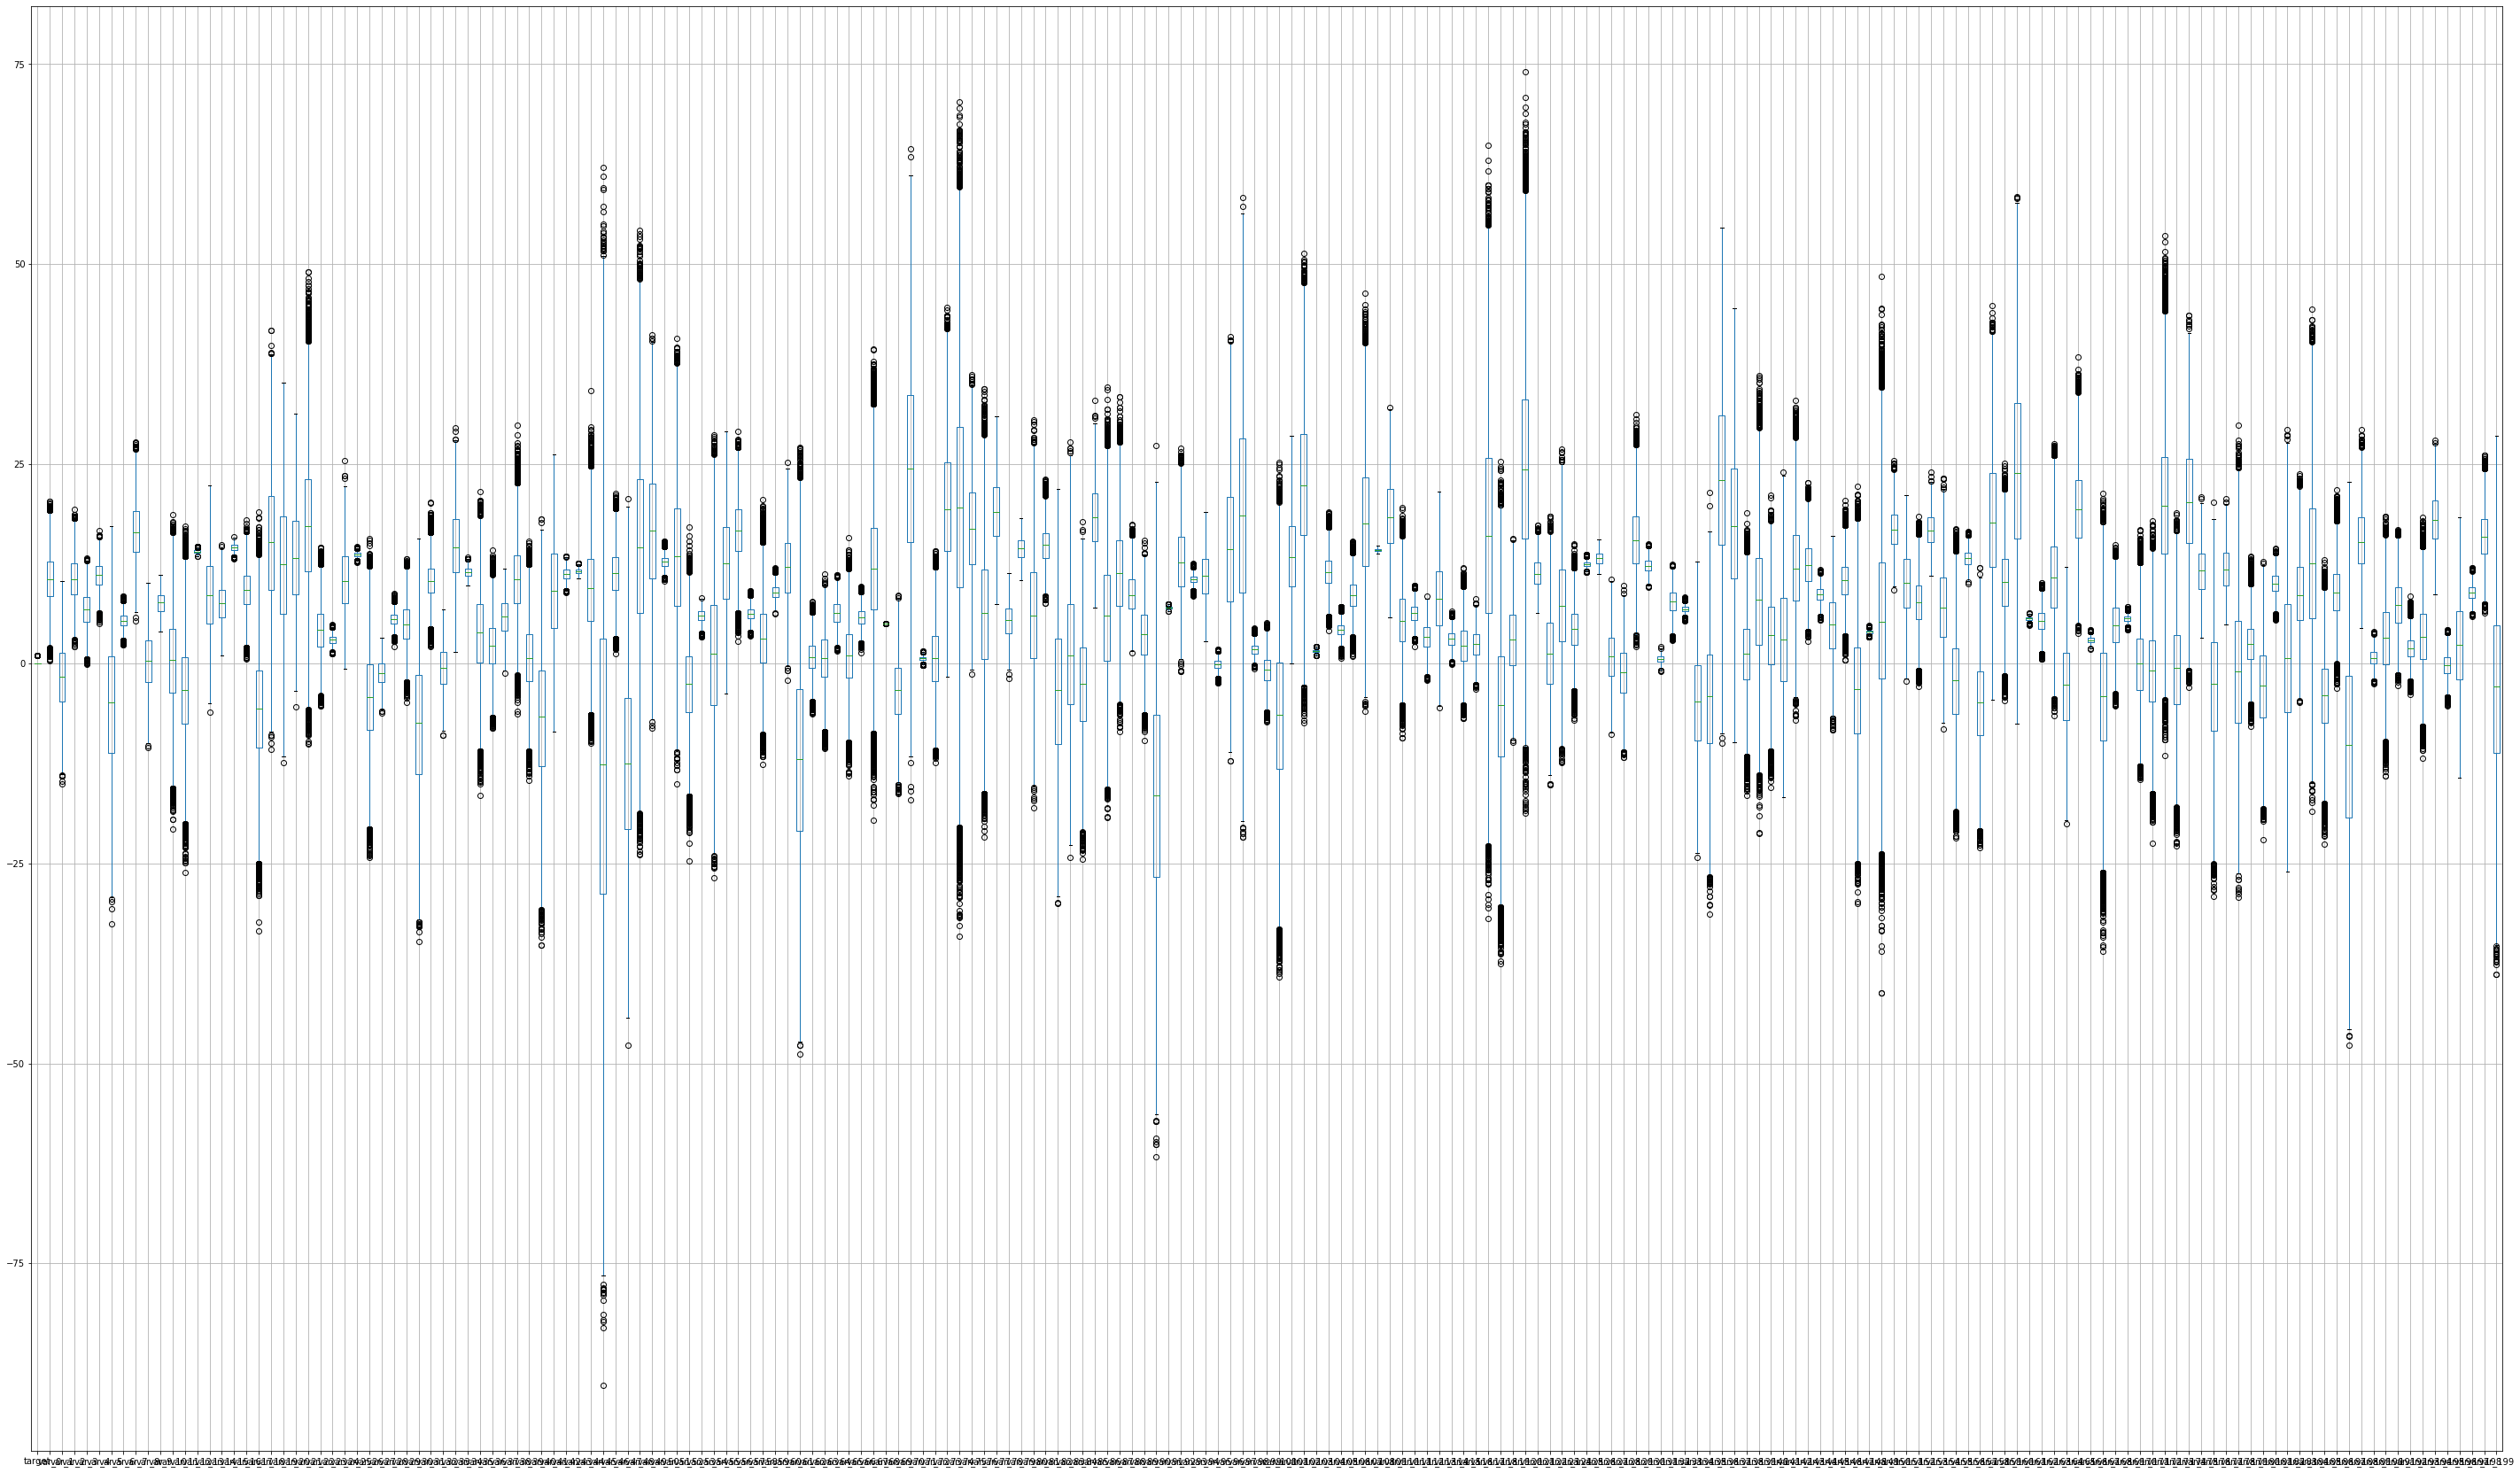

In [15]:
%matplotlib inline
Data_Train.boxplot(return_type="dict", figsize = (50,30))
plt.plot()  #We are having outliers in our data

Since out target class is imbalance we will not do any kind of outlier operation like removal 

### Relations of features with each other


In [16]:
%time
Data_Train[2:].corr()

Wall time: 0 ns


,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
target,1.000000,0.052389,0.050340,0.055873,0.011053,0.010916,0.030981,0.066731,-0.003024,0.019583,...,0.055976,0.047112,-0.042856,-0.017707,-0.022839,0.028285,0.023611,-0.035304,-0.053000,0.025436
var_0,0.052389,1.000000,-0.000547,0.006573,0.003799,0.001325,0.003043,0.006981,0.002431,0.004957,...,0.002752,0.000202,-0.005371,0.001613,-0.001512,0.002066,0.004387,-0.000754,-0.005780,0.003850
var_1,0.050340,-0.000547,1.000000,0.003987,0.000003,0.000307,-0.000900,0.003256,0.001515,0.004091,...,0.006632,0.003614,-0.002597,0.001157,-0.002559,-0.000791,-0.000367,-0.004160,-0.004865,0.002290
var_2,0.055873,0.006573,0.003987,1.000000,0.001007,0.000718,0.001561,0.000882,-0.000992,0.002647,...,0.000190,0.001287,-0.003404,0.000539,0.002109,-0.001075,0.003943,0.001080,-0.000880,0.003851
var_3,0.011053,0.003799,0.000003,0.001007,1.000000,-0.000318,0.003256,-0.000775,0.002502,0.003550,...,0.000155,0.002441,-0.001525,-0.001694,-0.001056,0.001205,-0.002792,0.001162,-0.001652,0.000508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
var_195,0.028285,0.002066,-0.000791,-0.001075,0.001205,0.003702,-0.001290,0.001239,0.001859,0.001377,...,0.004565,0.000860,-0.004742,-0.003161,-0.001194,1.000000,0.002517,-0.004172,-0.000550,0.002040
var_196,0.023611,0.004387,-0.000367,0.003943,-0.002792,0.000508,0.002875,0.005379,0.001042,-0.003239,...,-0.000854,0.002472,-0.001392,-0.005316,-0.005037,0.002517,1.000000,-0.000451,0.000254,0.000603
var_197,-0.035304,-0.000754,-0.004160,0.001080,0.001162,-0.000045,-0.000535,-0.003566,0.003467,-0.004585,...,-0.004973,0.000904,-0.000525,0.005069,0.000884,-0.004172,-0.000451,1.000000,0.001181,0.004991
var_198,-0.053000,-0.005780,-0.004865,-0.000880,-0.001652,-0.001823,-0.000962,-0.003027,0.000653,0.002938,...,-0.000155,-0.000073,0.003454,0.001636,0.003199,-0.000550,0.000254,0.001181,1.000000,-0.004732


In [17]:
Data_Test[2:].corr()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
var_0,1.000000,0.004235,0.002625,0.000844,-0.004256,0.002274,0.001932,-0.004652,-0.003674,0.001422,...,0.002669,0.001151,0.001101,0.002762,-0.003511,0.001446,-0.000757,-0.000379,-0.004064,0.001242
var_1,0.004235,1.000000,0.002901,-0.002160,0.000718,0.001389,0.003558,0.003016,0.000777,-0.002650,...,0.002040,0.003459,-0.003426,0.000342,0.000145,0.001316,-0.001629,-0.002866,-0.003026,0.001873
var_2,0.002625,0.002901,1.000000,-0.005886,0.003658,0.000282,-0.001144,-0.000276,0.001230,0.000038,...,-0.001762,0.001137,-0.005485,0.002026,-0.002389,0.001325,-0.002400,-0.002736,-0.001538,0.000233
var_3,0.000844,-0.002160,-0.005886,1.000000,-0.000965,0.001643,-0.003075,0.001944,-0.001452,-0.001302,...,-0.001616,0.002112,0.001281,-0.006128,0.000294,0.001591,0.003172,0.002772,-0.002620,-0.003038
var_4,-0.004256,0.000718,0.003658,-0.000965,1.000000,0.004822,-0.003281,-0.000164,0.003129,0.000084,...,-0.003095,0.002474,-0.000736,-0.000744,-0.000430,0.003046,-0.001322,0.000429,-0.002139,0.000391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
var_195,0.001446,0.001316,0.001325,0.001591,0.003046,0.002673,0.000974,0.004806,-0.003243,-0.002860,...,0.000907,-0.003872,0.000609,0.001950,0.000515,1.000000,-0.001348,-0.000689,0.003913,-0.003140
var_196,-0.000757,-0.001629,-0.002400,0.003172,-0.001322,-0.002445,-0.001600,0.001646,0.002759,0.001319,...,0.000334,0.003157,-0.001465,-0.000112,-0.000542,-0.001348,1.000000,0.002297,0.003351,0.002050
var_197,-0.000379,-0.002866,-0.002736,0.002772,0.000429,-0.003669,-0.003387,0.001443,-0.002953,0.002238,...,-0.002659,-0.001201,0.002303,0.000476,-0.002209,-0.000689,0.002297,1.000000,-0.002176,0.003374
var_198,-0.004064,-0.003026,-0.001538,-0.002620,-0.002139,-0.004627,0.000939,-0.000813,-0.001536,-0.002251,...,0.000253,-0.003149,0.000586,0.000549,-0.002758,0.003913,0.003351,-0.002176,1.000000,-0.000825


If we see the above : 
    1. The variables are  very less correlated to each other means they are independent of each other

### Relations of features with target variable


In [18]:
corr_matrix = Data_Train.corr()
corr_matrix['target'].sort_values(ascending = False)

target     1.000000
var_6      0.066731
var_110    0.064275
var_53     0.063399
var_26     0.062422
             ...   
var_76    -0.061917
var_146   -0.063644
var_12    -0.069489
var_139   -0.074080
var_81    -0.080917
Name: target, Length: 201, dtype: float64

If we see above what we find that features are not strongly correlated with the target variable

# Feature selection

It is really difficult to select the some specific features out of all bcz : 
    1. The Names of the features are not meaningful which inturn does not helps us in understanding their meaning.
    2. Also the correlation does not show if a variable  is strongly related with the output variable.

# Data Distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000224B08BA588>,
      dtype=object)

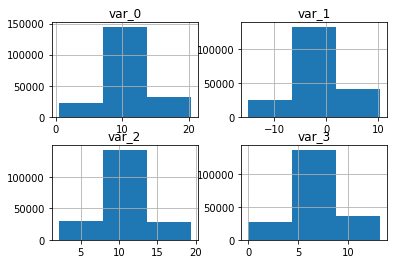

In [19]:
#Let see the distribution of our data whether it is  uniformely distributed or not
Data_Train[['var_0','var_1','var_2','var_3']].hist(bins=3)

So our data is uniformely distributed as shown above

In [20]:
Data_Train.shape

(200000, 202)

In [21]:
Data_Train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.522699,-2.3978,7.8784,8.5635,12.780300,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.430500,2.0339,8.1267,8.7889,18.356001,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.604200,3.1417,-6.5213,8.2675,14.722200,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.034700,-1.2706,-2.9275,10.2922,17.969700,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.287600,-1.5121,3.9267,9.5031,17.997400,-8.8104


## Feature Scaling

1. Since the data is uniformely distributed we will do standerdisation of our dataset.
2. Please note the Scaling of  our dataset  also helps in  improving the performance of our model in terms of speed of processing the input data.


In [22]:
#Standardization
for i in Data_Train.columns[2:202] :
    Data_Train[i] = ( Data_Train[i] - Data_Train[i].mean() )/ Data_Train[i].std()

In [23]:
#Standardization
for i in Data_Test.columns[1:202] :
    Data_Test[i] = ( Data_Test[i] - Data_Test[i].mean() )/ Data_Test[i].std()

In [24]:
#Lets have a look at our data after the standerdization is done
Data_Train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,-0.577131,-1.273757,0.451742,-0.833721,0.235624,-0.536436,-0.334948,0.608721,...,0.263378,-1.149193,0.817490,-0.411022,0.168698,-1.578150,1.022143,-0.374048,-1.026461,0.214139
1,train_1,0,0.269944,-0.622146,1.190410,-0.688856,0.791038,1.539929,0.244453,-0.003566,...,0.966624,0.093593,0.443637,1.908806,-0.817613,1.522371,1.067667,-0.129474,0.825382,0.505693
2,train_2,0,-0.681145,-0.276069,0.517024,0.536529,-0.305434,-0.511039,1.769866,-0.564799,...,-0.072094,0.777998,-0.174131,-0.412325,1.151598,2.297414,-1.617934,-0.695228,-0.381503,0.356687
3,train_3,0,0.125141,-0.129426,-0.667565,0.195362,0.928059,0.410682,0.500631,-0.474249,...,0.270220,-0.891486,-0.818481,-0.478558,1.607881,-0.789534,-0.959038,1.501705,0.697081,-0.543509
4,train_4,0,-0.277328,0.035612,0.817725,-0.077827,0.738670,0.955593,0.613372,0.791517,...,-1.036203,0.688987,-1.406013,1.468568,-1.501129,-0.958493,0.297628,0.645480,0.706281,-0.525383


In [25]:
Data_Train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05,...,2.000000e+05,200000.000000,200000.000000,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05
mean,0.100490,-0.000019,0.000001,0.000025,0.000003,0.000048,0.000003,-0.000014,-0.000040,7.822548e-07,...,7.680855e-07,-0.000013,0.000004,1.607911e-07,-0.000008,-0.000001,-0.000004,-0.000072,-0.000048,4.789671e-07
std,0.300653,1.000020,1.000019,1.000023,1.000021,1.000022,1.000019,1.000026,1.000020,1.000017e+00,...,1.000015e+00,1.000021,1.000024,1.000024e+00,1.000015,1.000022,1.000018,1.000024,1.000018,1.000018e+00
min,0.000000,-3.378818,-3.312563,-3.255801,-3.345961,-3.698727,-3.496993,-3.533019,-3.275676,-3.237634e+00,...,-3.800064e+00,-3.350794,-3.884186,-3.786428e+00,-2.966212,-3.581311,-3.027526,-3.198366,-3.178979,-3.403605e+00
25%,0.000000,-0.732280,-0.768499,-0.754554,-0.754889,-0.736289,-0.780226,-0.739986,-0.761317,-7.807652e-01,...,-7.222295e-01,-0.754513,-0.702155,-6.881810e-01,-0.754043,-0.719642,-0.779257,-0.711178,-0.677926,-7.551312e-01
50%,0.000000,-0.051060,0.004834,-0.051168,0.013937,0.018480,0.029529,-0.027534,-0.026093,3.286970e-02,...,-6.762573e-03,-0.030001,-0.017947,1.617687e-02,-0.011439,-0.021418,0.019351,-0.021728,0.020986,4.857253e-02
75%,0.000000,0.683630,0.737352,0.682199,0.747612,0.728766,0.761802,0.685494,0.748071,7.963032e-01,...,6.955845e-01,0.686051,0.691069,7.199585e-01,0.766388,0.679815,0.779823,0.743352,0.728641,7.820917e-01
max,1.000000,3.169428,2.964080,3.270891,3.128200,3.445936,2.838180,3.506568,3.260908,2.960815e+00,...,3.334858e+00,3.068942,4.379479,3.745058e+00,3.168941,3.088828,2.936806,3.355214,3.390435,3.049220e+00


# Model Development

## Logistic regression

In [26]:
#Training data
X=Data_Train.drop(['ID_code','target'],axis=1)
Y=Data_Train['target']

#StratifiedKFold cross validator
cv=StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
for train_index,valid_index in cv.split(X,Y):
    X_train, X_valid=X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid=Y.iloc[train_index], Y.iloc[valid_index]

print('Shape of X_train :',X_train.shape)
print('Shape of X_valid :',X_valid.shape)
print('Shape of y_train :',y_train.shape)
print('Shape of y_valid :',y_valid.shape)

Shape of X_train : (160001, 200)
Shape of X_valid : (39999, 200)
Shape of y_train : (160001,)
Shape of y_valid : (39999,)


In [27]:
%%time
#Logistic regression model
lr_model=LogisticRegression(random_state=42)
#fitting the lr model
lr_model.fit(X_train,y_train)

Wall time: 29.4 s
Parser   : 105 ms


In [28]:
#Accuracy of the model
lr_score=lr_model.score(X_train,y_train)
print('Accuracy of the lr_model :',lr_score)

Accuracy of the lr_model : 0.9149130317935513


In [29]:
%%time
#Cross validation prediction
cv_predict=cross_val_predict(lr_model,X_valid,y_valid,cv=5)
#Cross validation score
cv_score=cross_val_score(lr_model,X_valid,y_valid,cv=5)
print('cross_val_score :',np.average(cv_score))

cross_val_score : 0.9120978747343418
Wall time: 22.4 s


[[35422   558]
 [ 2958  1061]]


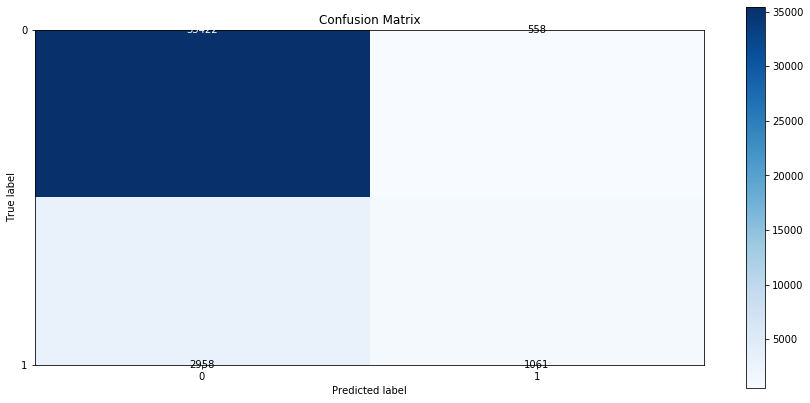

In [30]:
#Confusion matrix
cm=confusion_matrix(y_valid,cv_predict)
print(cm)
#Plot the confusion matrix
plot_confusion_matrix(y_valid,cv_predict,normalize=False,figsize=(15,7))

    Accuracy of the model is not the best metric to use when evaluating the imbalanced datasets as it may be misleading. So, we are going to change the performance metric.

ROC score : 0.6242437015062279


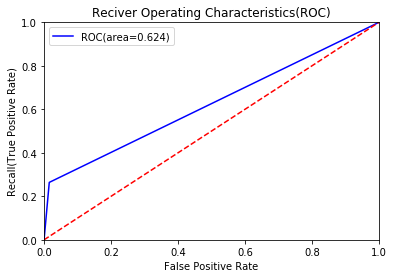

AUC: 0.6242437015062279


In [31]:
#ROC_AUC score
roc_score=roc_auc_score(y_valid,cv_predict)
print('ROC score :',roc_score)

#ROC_AUC curve
plt.figure()
false_positive_rate,recall,thresholds=roc_curve(y_valid,cv_predict)
roc_auc=auc(false_positive_rate,recall)
plt.title('Reciver Operating Characteristics(ROC)')
plt.plot(false_positive_rate,recall,'b',label='ROC(area=%0.3f)' %roc_auc)
plt.legend()
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall(True Positive Rate)')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC:',roc_auc)

The roc auc score is not good even though the accuracy is 91%. so since the auc score is not good this model is not accurate.

In [32]:
#Classification report
scores=classification_report(y_valid,cv_predict)
print(scores)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     35980
           1       0.66      0.26      0.38      4019

    accuracy                           0.91     39999
   macro avg       0.79      0.62      0.66     39999
weighted avg       0.90      0.91      0.89     39999



If you see above, 
    
    The precision and recall is really good for class 0 whereas these are not good for class 1. 

    note : class 0 - customer will not make a transaction
       class 1 - customer will make a transaction
       
    So since the f1-score(harmonic mean of precision and recall) for customer who will be making a transaction is 0.38   which is not good and also
    auc score is 0.62 which is not a good accuracy. Hence 
    we are rejecting this model

## Random forest classifier

In [33]:
%%time
#Random forest classifier
rf_model=RandomForestClassifier(n_estimators=10,random_state=42)
#fitting the model
rf_model.fit(X_train,y_train)

Wall time: 2min 7s


In [34]:
#Accuracy of the model
rf_score=rf_model.score(X_train,y_train)
print('Accuracy of the rf_model :',rf_score)

Accuracy of the rf_model : 0.9855000906244336


In [35]:
%%time
#Cross validation prediction
cv_predict=cross_val_predict(rf_model,X_valid,y_valid,cv=5)
#Cross validation score
cv_score=cross_val_score(rf_model,X_valid,y_valid,cv=5)
print('cross_val_score :',np.average(cv_score))

cross_val_score : 0.8995225121890236
Wall time: 3min


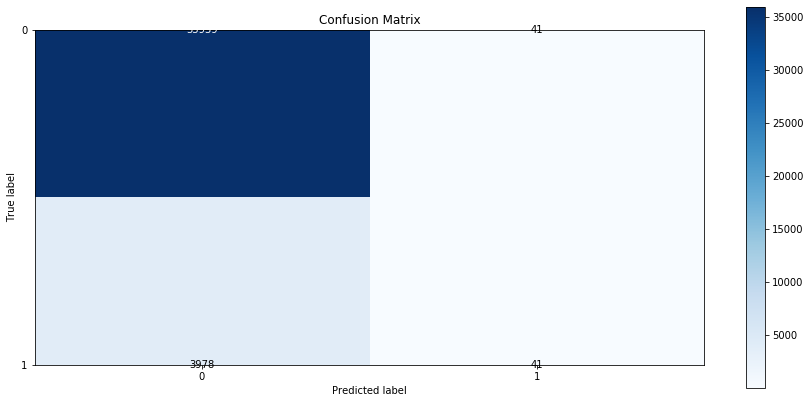

In [36]:
#Confusion matrix
cm=confusion_matrix(y_valid,cv_predict)
#Plot the confusion matrix
plot_confusion_matrix(y_valid,cv_predict,normalize=False,figsize=(15,7))

    Accuracy of the model is not the best metric to use when evaluating the imbalanced datasets as it may be misleading. So, we are going to change the performance metric.

ROC score : 0.504531010357832


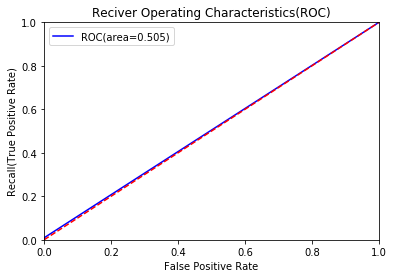

AUC: 0.504531010357832


In [37]:
#ROC_AUC score
roc_score=roc_auc_score(y_valid,cv_predict)
print('ROC score :',roc_score)

#ROC_AUC curve
plt.figure()
false_positive_rate,recall,thresholds=roc_curve(y_valid,cv_predict)
roc_auc=auc(false_positive_rate,recall)
plt.title('Reciver Operating Characteristics(ROC)')
plt.plot(false_positive_rate,recall,'b',label='ROC(area=%0.3f)' %roc_auc)
plt.legend()
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall(True Positive Rate)')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC:',roc_auc)

In [38]:
#Classification report
scores=classification_report(y_valid,cv_predict)
print(scores)

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     35980
           1       0.50      0.01      0.02      4019

    accuracy                           0.90     39999
   macro avg       0.70      0.50      0.48     39999
weighted avg       0.86      0.90      0.85     39999



If you see above, 
    
    The precision and recall is really good for class 0 whereas these are not good for class 1. 

    note : class 0 - customer will not make a transaction
       class 1 - customer will make a transaction
       
    So since the f1-score(harmonic mean of precision and recall) for customer who will be making a transaction is 0.02   which is not good and also
    auc score is 0.50 which is not a good accuracy. Hence 
    we are rejecting this model

In [39]:
%%time
#Predicting the model
X_test=Data_Test.drop(['ID_code'],axis=1)
rf_pred=rf_model.predict(X_test)
print(rf_pred)

[0 0 0 ... 0 0 0]
Wall time: 43.9 s


## Synthetic Minority Oversampling Technique(SMOTE)

In [40]:
%%time
from imblearn.over_sampling import SMOTE
#Synthetic Minority Oversampling Technique
sm = SMOTE(random_state=42, ratio=1.0)
#Generating synthetic data points
X_smote,y_smote=sm.fit_sample(X_train,y_train)
X_smote_v,y_smote_v=sm.fit_sample(X_valid,y_valid)

Using TensorFlow backend.


Wall time: 5min 7s
Parser   : 238 ms


In [41]:
%%time
#Logistic regression model for SMOTE
smote=LogisticRegression(random_state=42)
#fitting the smote model
smote.fit(X_smote,y_smote)

Wall time: 39.1 s


In [42]:
#Accuracy of the model
smote_score=smote.score(X_smote,y_smote)
print('Accuracy of the smote_model :',smote_score)

Accuracy of the smote_model : 0.79952335292728


In [43]:
%%time
#Cross validation prediction
cv_pred=cross_val_predict(smote,X_smote_v,y_smote_v,cv=5)
#Cross validation score
cv_score=cross_val_score(smote,X_smote_v,y_smote_v,cv=5)
print('cross_val_score :',np.average(cv_score))

cross_val_score : 0.8042106725958866
Wall time: 23.7 s


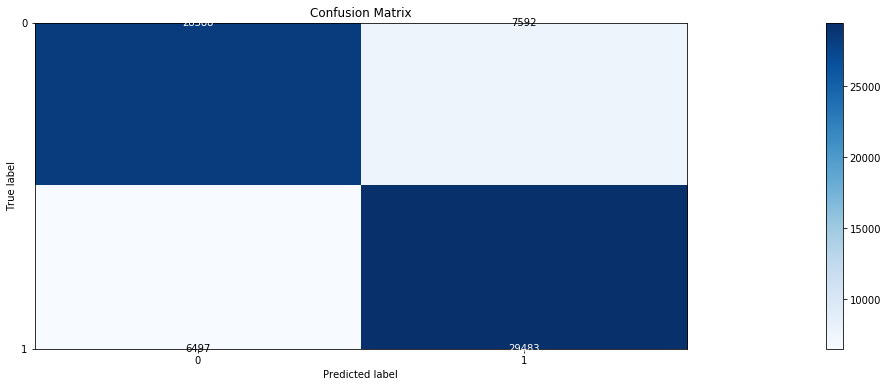

In [44]:
#Confusion matrix
cm=confusion_matrix(y_smote_v,cv_pred)
#Plot the confusion matrix
plot_confusion_matrix(y_smote_v,cv_pred,normalize=False,figsize=(50,6))

    Accuracy of the model is not the best metric to use when evaluating the imbalanced datasets as it may be misleading. So, we are going to change the performance metric.

ROC score : 0.8042106725958866


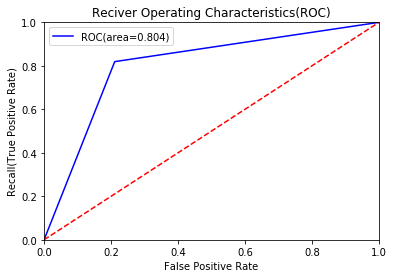

AUC: 0.8042106725958866


In [45]:
#ROC_AUC score
roc_score=roc_auc_score(y_smote_v,cv_pred)
print('ROC score :',roc_score)

#ROC_AUC curve
plt.figure()
false_positive_rate,recall,thresholds=roc_curve(y_smote_v,cv_pred)
roc_auc=auc(false_positive_rate,recall)
plt.title('Reciver Operating Characteristics(ROC)')
plt.plot(false_positive_rate,recall,'b',label='ROC(area=%0.3f)' %roc_auc)
plt.legend()
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall(True Positive Rate)')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC:',roc_auc)

In [46]:
#Classification report
scores=classification_report(y_smote_v,cv_pred)
print(scores)

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     35980
           1       0.80      0.82      0.81     35980

    accuracy                           0.80     71960
   macro avg       0.80      0.80      0.80     71960
weighted avg       0.80      0.80      0.80     71960



If you see above, 
    
    The precision and recall is really good for  both class 0 and class 1 which is a positive outcome as compared to the previous model Logistic Regression and Random forest 

    note : class 0 - customer will not make a transaction
       class 1 - customer will make a transaction
       
    So since the f1-score(harmonic mean of precision and recall) for customer who will be making a transaction is 0.81   which is good and also
    auc score is 0.80 which is a good accuracy. 
    
    Still we will see other model to see if that has good accuracy that this or not

In [47]:
%%time
#Predicting the model
X_test=Data_Test.drop(['ID_code'],axis=1)
smote_pred=smote.predict(X_test)
print(smote_pred)

[1 1 0 ... 0 0 1]
Wall time: 17.2 s


We can observed that smote model is performing well on imbalance data compare to logistic regression.

## LightGBM

In [48]:
#Training the model
#training data
lgb_train=lgb.Dataset(X_train,label=y_train)
#validation data
lgb_valid=lgb.Dataset(X_valid,label=y_valid)

In [49]:
#Selecting best hyperparameters by tuning of different parameters
params={'boosting_type': 'gbdt', 
          'max_depth' : -1, #no limit for max_depth if <0
          'objective': 'binary',
          'boost_from_average':False, 
          'nthread': 20,
          'metric':'auc',
          'num_leaves': 50,
          'learning_rate': 0.01,
          'max_bin': 100,      #default 255
          'subsample_for_bin': 100,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'bagging_fraction':0.5,
          'bagging_freq':5,
          'feature_fraction':0.08,
          'min_split_gain': 0.45, #>0
          'min_child_weight': 1,
          'min_child_samples': 5,
          'is_unbalance':True,
          }

In [50]:
num_rounds=10000
lgbm= lgb.train(params,lgb_train,num_rounds,valid_sets=[lgb_valid],verbose_eval=1000,early_stopping_rounds = 5000)
lgbm

Training until validation scores don't improve for 5000 rounds
[1000]	valid_0's auc: 0.886019
[2000]	valid_0's auc: 0.890509
[3000]	valid_0's auc: 0.892263
[4000]	valid_0's auc: 0.892743
[5000]	valid_0's auc: 0.892648
[6000]	valid_0's auc: 0.892597
[7000]	valid_0's auc: 0.892408
[8000]	valid_0's auc: 0.892172
[9000]	valid_0's auc: 0.892079
Early stopping, best iteration is:
[4559]	valid_0's auc: 0.892869


In [52]:
y_predict_prob=lgbm.predict(X_valid,random_state=42,num_iteration=lgbm.best_iteration)
#Convert to binary output 1 or 0
y_predict=np.where(y_predict_prob>=0.5,1,0)
print(y_predict_prob)
print(y_predict)

[0.13489104 0.05221606 0.02489441 ... 0.0712151  0.03670224 0.47650236]
[0 0 0 ... 0 0 0]


In [53]:
#Confusion matrix
cm = confusion_matrix(y_valid, y_predict)
#Accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_predict,y_valid)
print(accuracy)
print(cm)

0.8790219755493888
[[32366  3614]
 [ 1225  2794]]


In [54]:
X_test=Data_Test.drop(['ID_code'],axis=1)
#predict the model
#probability predictions
lgbm_predict_prob=lgbm.predict(X_test,random_state=42,num_iteration=lgbm.best_iteration)
#Convert to binary output 1 or 0
lgbm_predict=np.where(lgbm_predict_prob>=0.5,1,0)
print(lgbm_predict_prob)
print(lgbm_predict)

[0.47886149 0.48950873 0.52232993 ... 0.02372948 0.27518755 0.32688538]
[0 0 1 ... 0 0 0]


**Let us plot the important features**

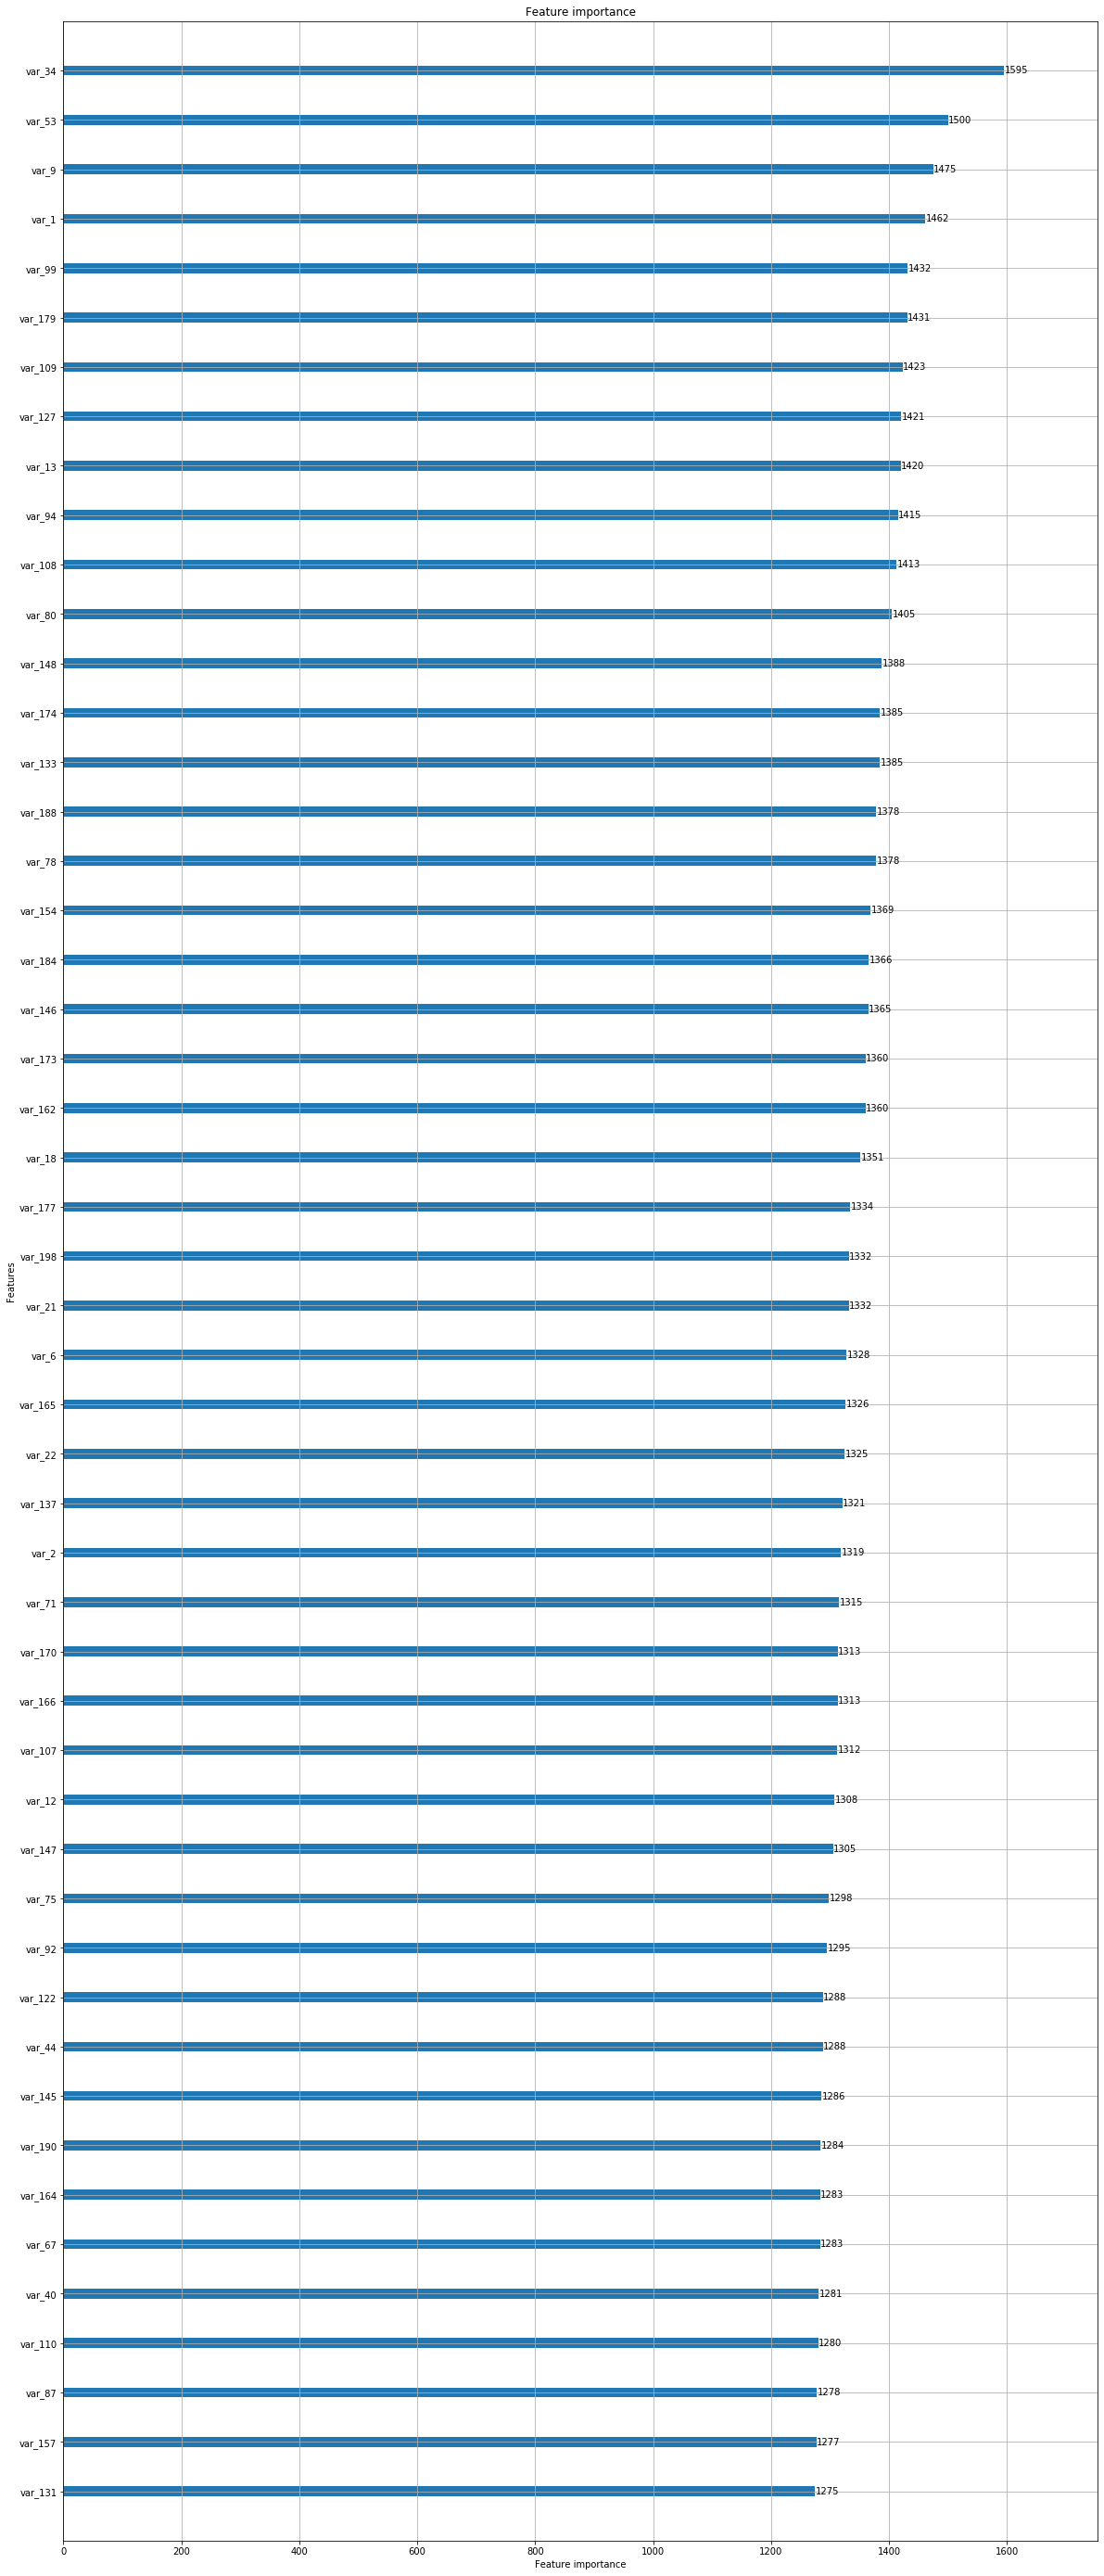

In [55]:
#plot the important features
lgb.plot_importance(lgbm,max_num_features=50,importance_type="split",figsize=(20,50))

    The model light GBM is having auc score of 0.88 which is larger than auc score of SMOTE(0.80). Hence we will select lightGBM as our model since its  accuracy is good that that of SMOTE

In [57]:
#final submission
sub_df=pd.DataFrame({'ID_code':Data_Test['ID_code'].values})
sub_df['lgbm_predict_prob']=lgbm_predict_prob
sub_df['lgbm_predict']=lgbm_predict
sub_df.to_csv('submission.csv',index=False)
sub_df.head()

,ID_code,lgbm_predict_prob,lgbm_predict
0,test_0,0.478861,0
1,test_1,0.489509,0
2,test_2,0.522330,1
3,test_3,0.493493,0
4,test_4,0.178633,0


## Deployment

In [59]:
# Saving model to disk
import pickle
pickle.dump(lgbm, open('model.pkl','wb'))

In [61]:
# Loading model to compare the results
model = pickle.load(open('model.pkl','rb'))

In [62]:
#predict 
lgbm_pred=model.predict(X_test) 